In [2]:
import torch
#import open_clip
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
!pip install seaborn


In [4]:
#import open_clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="ViT-B-16",
    pretrained="laion400m_e31"
)

tokenizer = open_clip.get_tokenizer("ViT-B-16")

model.to(device)
model.eval()

print("Loaded:", "ViT-B-16 (laion400m_e31)")
print("Device:", next(model.parameters()).device)


NameError: name 'open_clip' is not defined

CIFAR10

In [ ]:
# CELL 3: CIFAR-10 classes + smart prompt ensemble (3 templates = perfect speed/accuracy)
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

test_set = CIFAR10(root='./data', train=False, download=True, transform=preprocess)
test_loader = DataLoader(test_set, batch_size=128)

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

templates = [
    "a photo of a {}.",
    "a blurry photo of a {}.",
    "a photo of a small {}.",
    "a close-up photo of a {}.",
    "a cropped photo of a {}.",
    "a bright photo of a {}.",
    "a low-resolution photo of a {}.",
    "a clean photo of a {}.",
    "a pixelated photo of a {}.",
]

print(f"Using {len(templates)} templates.")



Files already downloaded and verified
Using 9 templates.


In [ ]:
# BUILD TEXT FEATURES (correct tokenizer)
text_features = []

for classname in cifar10_classes:
    texts = [t.format(classname) for t in templates]
    tokens = tokenizer(texts).to(device)

    with torch.no_grad():
        emb = model.encode_text(tokens)
        emb = emb / emb.norm(dim=-1, keepdim=True)

    text_features.append(emb.mean(0))

text_features = torch.stack(text_features)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

In [ ]:
# RUN ZERO-SHOT
all_predictions = []
all_scores = []
true_labels = np.array(test_set.targets)

with torch.no_grad():
    for images, _ in tqdm(test_loader):
        images = images.to(device)

        img_feat = model.encode_image(images)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

        sim = (100 * img_feat @ text_features.T).softmax(dim=-1)

        all_scores.append(sim.cpu())
        all_predictions.extend(sim.argmax(dim=1).cpu().numpy())

predictions = np.array(all_predictions)
full_scores = torch.cat(all_scores).numpy()


100%|██████████| 79/79 [02:14<00:00,  1.70s/it]


=== OVERALL METRICS ===
Accuracy           : 91.61%
Precision (Macro)  : 91.88%
Recall/Sensitivity : 91.61%
Specificity (Macro): 99.07%

=== PER-CLASS METRICS ===
     Class  Precision  Recall  F1-score  Support
  airplane     0.9765   0.916    0.9453   1000.0
automobile     0.9902   0.911    0.9490   1000.0
      bird     0.8725   0.917    0.8942   1000.0
       cat     0.8338   0.878    0.8553   1000.0
      deer     0.9107   0.877    0.8935   1000.0
       dog     0.8976   0.877    0.8872   1000.0
      frog     0.9726   0.852    0.9083   1000.0
     horse     0.8942   0.972    0.9315   1000.0
      ship     0.9528   0.969    0.9608   1000.0
     truck     0.8873   0.992    0.9367   1000.0


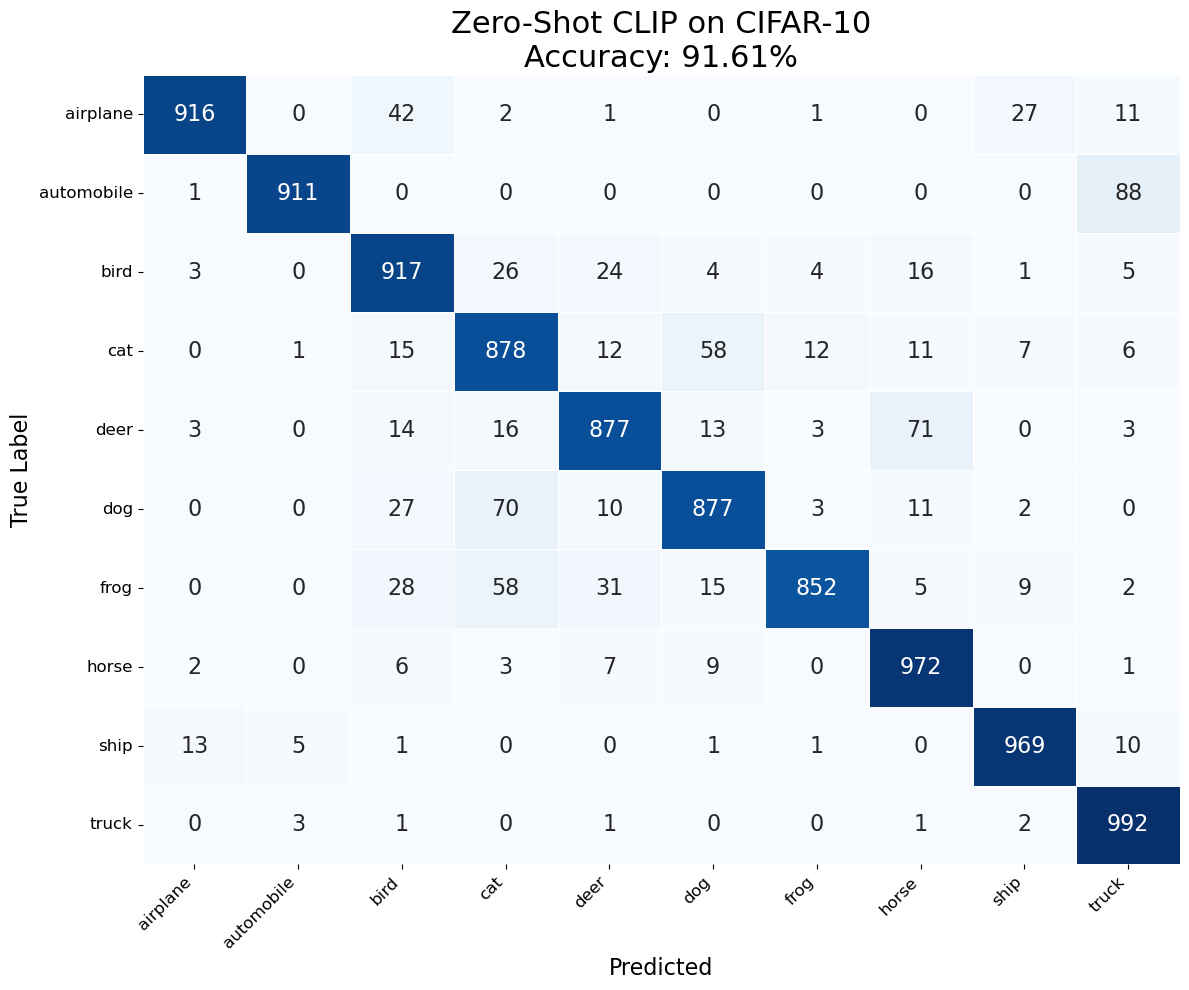

In [ ]:
# CELL 6 — FINAL METRICS FOR PRESENTATION
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ground truth and predictions (from your evaluation loop)
y_true   = np.array(true_labels)
y_pred   = np.array(predictions)

# -----------------------------
# 1. Precision, Recall, F1 (Per-class + Macro)
# -----------------------------
report = classification_report(
    y_true, y_pred,
    target_names=cifar10_classes,
    digits=4,
    output_dict=True
)

# Build per-class table
per_class_metrics = pd.DataFrame({
    "Class": cifar10_classes,
    "Precision": [report[c]['precision'] for c in cifar10_classes],
    "Recall": [report[c]['recall'] for c in cifar10_classes],
    "F1-score": [report[c]['f1-score'] for c in cifar10_classes],
    "Support": [report[c]['support'] for c in cifar10_classes]
}).round(4)

# -----------------------------
# 2. Global Metrics (what you will PRESENT)
# -----------------------------
accuracy = np.mean(y_pred == y_true)

macro_precision = report['macro avg']['precision']
macro_recall    = report['macro avg']['recall']
macro_f1        = report['macro avg']['f1-score']

# ---- Specificity (per class) ----
cm = confusion_matrix(y_true, y_pred)
specificities = []

for i in range(len(cifar10_classes)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp)
    specificities.append(specificity)

macro_specificity = np.mean(specificities)

# -----------------------------
# PRINT SUMMARY FOR REPORT
# -----------------------------
print("=== OVERALL METRICS ===")
print(f"Accuracy           : {accuracy*100:.2f}%")
print(f"Precision (Macro)  : {macro_precision*100:.2f}%")
print(f"Recall/Sensitivity : {macro_recall*100:.2f}%")
print(f"Specificity (Macro): {macro_specificity*100:.2f}%")

print("\n=== PER-CLASS METRICS ===")
print(per_class_metrics.to_string(index=False))

# -----------------------------
# 3. Confusion Matrix Plot
# -----------------------------
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cifar10_classes, yticklabels=cifar10_classes,
            linewidths=0.5, cbar=False,
            annot_kws={'size':16})
plt.title(f"Zero-Shot CLIP on CIFAR-10\nAccuracy: {accuracy*100:.2f}%", fontsize=22)
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


ZERO-SHOT CIFAR-10 – COMPLETE RESULTS
Top-1 Accuracy       : 0.9161  →  91.61%
Top-3 Accuracy       : 0.9853  →  98.53%
Top-5 Accuracy       : 0.9957  →  99.57%
Balanced Accuracy    : 0.9161
Matthews Corr Coef   : 0.9071
Macro F1-score       : 0.9162
Weighted F1-score    : 0.9162
Macro Specificity    : 0.9907

Per-class Accuracy (worst → best)
     Class  Accuracy  Specificity
      frog     0.852       0.9973
      deer     0.877       0.9904
       dog     0.877       0.9889
       cat     0.878       0.9806
automobile     0.911       0.9990
  airplane     0.916       0.9976
      bird     0.917       0.9851
      ship     0.969       0.9947
     horse     0.972       0.9872
     truck     0.992       0.9860


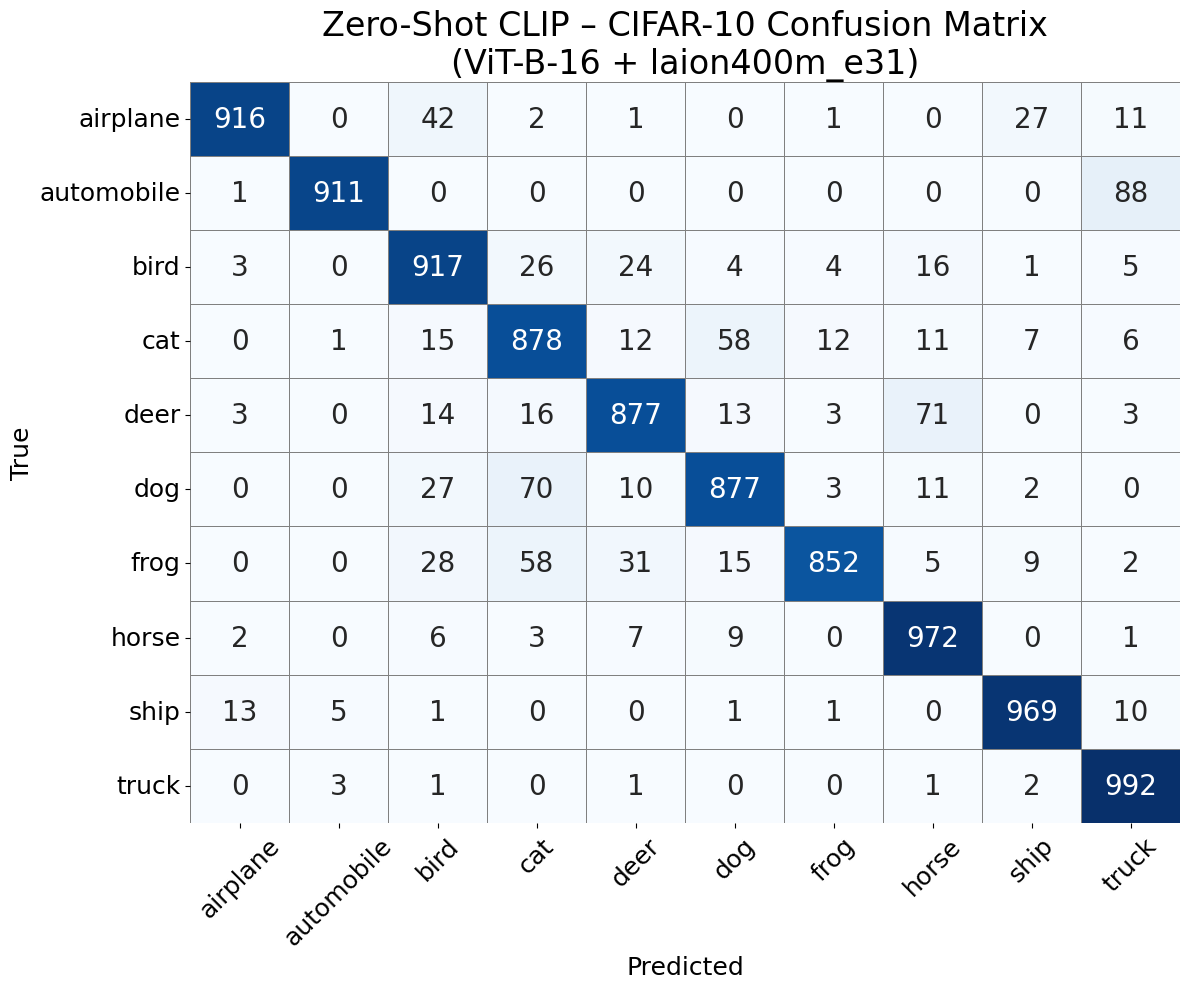

In [ ]:
# CELL 6 – ALL METRICS YOU WILL EVER NEED (research-grade)
from sklearn.metrics import (
    classification_report, confusion_matrix, top_k_accuracy_score,
    balanced_accuracy_score, matthews_corrcoef, precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert everything to numpy once
y_true = true_labels
y_pred = predictions
y_scores = full_scores  # shape (10000, 10)

# 1. Top-k accuracies
top1 = np.mean(y_pred == y_true)
top3 = top_k_accuracy_score(y_true, y_scores, k=3)
top5 = top_k_accuracy_score(y_true, y_scores, k=5)

# 2. All classification metrics
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# 3. Specificity (macro-averaged)
cm = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(10):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity_per_class.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
specificity_macro = np.mean(specificity_per_class)

# 4. Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# PRINT EVERYTHING BEAUTIFULLY
print("ZERO-SHOT CIFAR-10 – COMPLETE RESULTS")
print("="*60)
print(f"Top-1 Accuracy       : {top1:.4f}  →  {top1*100:05.2f}%")
print(f"Top-3 Accuracy       : {top3:.4f}  →  {top3*100:05.2f}%")
print(f"Top-5 Accuracy       : {top5:.4f}  →  {top5*100:05.2f}%")
print(f"Balanced Accuracy    : {balanced_acc:.4f}")
print(f"Matthews Corr Coef   : {mcc:.4f}")
print(f"Macro F1-score       : {f1_macro:.4f}")
print(f"Weighted F1-score    : {f1_weighted:.4f}")
print(f"Macro Specificity    : {specificity_macro:.4f}")

# Per-class table (sorted)
df_per_class = pd.DataFrame({
    'Class': cifar10_classes,
    'Accuracy': per_class_acc,
    'Specificity': specificity_per_class
}).sort_values('Accuracy')

print("\nPer-class Accuracy (worst → best)")
print(df_per_class.round(4).to_string(index=False))

# Confusion matrix
plt.figure(figsize=(12, 10))

ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=cifar10_classes,
    yticklabels=cifar10_classes,
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)

# FORCE all annotation numbers to be bigger
for t in ax.texts:
    t.set_fontsize(20)   # ← change this number to any size you want

plt.title(
    'Zero-Shot CLIP – CIFAR-10 Confusion Matrix\n(ViT-B-16 + laion400m_e31)',
    fontsize=24
)

plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
plt.tight_layout()
plt.show()

covid-chestxray-dataset

In [ ]:
# import os
# import torch
# import pandas as pd
# from PIL import Image
# from tqdm import tqdm
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as T
# import open_clip

# # -------------------------
# # 1. Dataset
# # -------------------------
# class ChestXrayDataset(Dataset):
#     def __init__(self, df, image_root, transform=None):
#         self.image_root = image_root
#         self.transform = transform

#         VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp")

#         # keep only real images
#         df = df[df["filename"].str.lower().str.endswith(VALID_EXT)]

#         self.df = df.reset_index(drop=True)
#         print("Filtered dataset size:", len(self.df))

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         img_path = os.path.join(self.image_root, row["filename"])

#         try:
#             image = Image.open(img_path).convert("RGB")
#         except:
#             print("BROKEN IMAGE:", img_path)
#             image = Image.new("RGB", (224, 224), color=0)

#         if self.transform:
#             image = self.transform(image)

#         return image, row["label"], row["filename"]

#     def __len__(self):
#         return len(self.df)


# # -------------------------
# # 2. Settings
# # -------------------------
# metadata_csv = "covid-chestxray-dataset/metadata.csv"
# image_root = "covid-chestxray-dataset/images"
# batch_size = 16
# device = "cuda" if torch.cuda.is_available() else "cpu"


# # -------------------------
# # 3. CLIP Transform
# # -------------------------
# preprocess = T.Compose([
#     T.Resize((224,224)),
#     T.Grayscale(num_output_channels=3),
#     T.ToTensor(),
#     T.Normalize(
#         mean=[0.48145466, 0.4578275, 0.40821073],
#         std=[0.26862954, 0.26130258, 0.27577711]
#     )
# ])


# # -------------------------
# # 4. Load metadata
# # -------------------------
# df = pd.read_csv(metadata_csv)

# # Create simplified label column
# # -------------------------
# def map_label(x):
#     x = str(x).lower()
#     if "covid" in x:
#         return 0
#     elif "pneumonia" in x:
#         return 1
#     else:
#         return 2  # Normal / Others

# df["label"] = df["finding"].apply(map_label)


# # -------------------------
# # 5. Create Dataset + Loader
# # -------------------------
# dataset = ChestXrayDataset(df, image_root, transform=preprocess)

# loader = DataLoader(
#     dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=True
# )

# print("Dataset size:", len(dataset))


# # -------------------------
# # 6. Load CLIP model
# # -------------------------
# model, _, _ = open_clip.create_model_and_transforms(
#     "ViT-B-16",
#     pretrained="laion400m_e31"
# )
# model = model.to(device)
# model.eval()

# tokenize = open_clip.tokenize


# # -------------------------
# # 7. Zero-shot prompts
# # -------------------------
# class_names = ["COVID-19", "Pneumonia", "Normal"]
# prompts = [f"A chest X-ray showing {c}." for c in class_names]

# with torch.no_grad():
#     text_tokens = tokenize(prompts).to(device)
#     text_embeds = model.encode_text(text_tokens)
#     text_embeds /= text_embeds.norm(dim=-1, keepdim=True)


# # -------------------------
# # 8. Zero-shot inference
# # -------------------------
# print("\nRunning zero-shot classification...")
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for images, labels, filenames in tqdm(loader):
#         images = images.to(device)

#         img_feats = model.encode_image(images)
#         img_feats /= img_feats.norm(dim=-1, keepdim=True)

#         logits = img_feats @ text_embeds.T
#         preds = logits.argmax(dim=1)

#         all_preds.extend(preds.cpu().tolist())
#         all_labels.extend(labels.tolist())


# # -------------------------
# # 9. Accuracy
# # -------------------------
# all_preds = torch.tensor(all_preds)
# all_labels = torch.tensor(all_labels)

# acc = (all_preds == all_labels).float().mean().item()
# print("\nZero-shot Accuracy:", acc)


Filtered dataset size: 929
Dataset size: 929

Running zero-shot classification...


 24%|██▎       | 14/59 [00:16<00:54,  1.21s/it]


KeyboardInterrupt: 

In [ ]:
import os
import re
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import open_clip

# ==========================================================
# 1. Label Cleaning + Mapping (your code, fully integrated)
# ==========================================================
metadata_csv = "covid-chestxray-dataset/metadata.csv"
df = pd.read_csv(metadata_csv)

def normalize_label(x):
    if pd.isna(x):
        return "Unknown"
    x = str(x).strip()
    x = x.replace("\t", "")
    x = re.sub(r"\s+", " ", x)
    x = x.strip("/ ")
    return x

df["finding_clean"] = df["finding"].apply(normalize_label)

MERGE_MAP = {
    # unknown
    "todo": "Unknown",
    "Unknown": "Unknown",

    # normal
    "No Finding": "Normal",

    # viral
    "Pneumonia/Viral/COVID-19": "Pneumonia-Viral",
    "Pneumonia/Viral/SARS": "Pneumonia-Viral",
    "Pneumonia/Viral/MERS-CoV": "Pneumonia-Viral",
    "Pneumonia/Viral/Influenza": "Pneumonia-Viral",
    "Pneumonia/Viral/Influenza/H1N1": "Pneumonia-Viral",
    "Pneumonia/Viral/Varicella": "Pneumonia-Viral",
    "Pneumonia/Viral/Herpes": "Pneumonia-Viral",

    # fungal
    "Pneumonia/Fungal/Pneumocystis": "Pneumonia-Fungal",
    "Pneumonia/Fungal/Aspergillosis": "Pneumonia-Fungal",

    # bacterial
    "Pneumonia/Bacterial": "Pneumonia-Bacterial",
    "Pneumonia/Bacterial/Streptococcus": "Pneumonia-Bacterial",
    "Pneumonia/Bacterial/E.Coli": "Pneumonia-Bacterial",
    "Pneumonia/Bacterial/Klebsiella": "Pneumonia-Bacterial",
    "Pneumonia/Bacterial/Legionella": "Pneumonia-Bacterial",
    "Pneumonia/Bacterial/Chlamydophila": "Pneumonia-Bacterial",
    "Pneumonia/Bacterial/Mycoplasma": "Pneumonia-Bacterial",
    "Pneumonia/Bacterial/Nocardia": "Pneumonia-Bacterial",
    "Pneumonia/Bacterial/Staphylococcus/MRSA": "Pneumonia-Bacterial",

    # other
    "Pneumonia/Lipoid": "Pneumonia-Other",
    "Pneumonia/Aspiration": "Pneumonia-Other",
}

def merge_labels(x):
    return MERGE_MAP.get(x, x)

df["finding_clean"] = df["finding_clean"].apply(merge_labels)

def simplify_multilabel(label):
    if "/" not in label:
        return label
    parts = [normalize_label(p) for p in label.split("/")]
    parts = [merge_labels(p) for p in parts]
    parts = list(set(parts))
    if len(parts) == 1:
        return parts[0]
    return "Mixed-" + "-".join(sorted(parts))

df["finding_clean"] = df["finding_clean"].apply(simplify_multilabel)

FOUR_CLASS_MAP = {
    "Normal": "Normal",
    "Pneumonia-Viral": "Viral",
    "Pneumonia-Bacterial": "Bacterial",
    "Pneumonia-Fungal": "Other",
    "Pneumonia-Other": "Other",
    "Mixed-Pneumonia-Viral-Pneumonia-Bacterial": "Other",
    "Mixed-Pneumonia-Viral-Pneumonia-Fungal": "Other",
    "Mixed-Pneumonia-Bacterial-Pneumonia-Fungal": "Other",
    "Tuberculosis": "Other",
    "Unknown": "Other",
}

def map_to_four(x):
    return FOUR_CLASS_MAP.get(x, "Other")

df["label_final"] = df["finding_clean"].apply(map_to_four)

print("\nClass counts after cleaning:")
print(df["label_final"].value_counts())

# Label encoding
label_to_idx = {"Normal": 0, "Viral": 1, "Bacterial": 2, "Other": 3}
df["label_idx"] = df["label_final"].map(label_to_idx)


# ==========================================================
# 2. Dataset
# ==========================================================
class ChestXrayDataset(Dataset):
    def __init__(self, df, image_root, transform=None):
        VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp")
        self.df = df[df["filename"].str.lower().str.endswith(VALID_EXT)].reset_index(drop=True)
        self.image_root = image_root
        self.transform = transform
        print("Filtered dataset size:", len(self.df))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_root, row["filename"])

        try:
            img = Image.open(img_path).convert("RGB")
        except:
            print("BROKEN IMAGE:", img_path)
            img = Image.new("RGB", (224, 224), color=0)

        if self.transform:
            img = self.transform(img)

        return img, row["label_idx"], row["filename"]

    def __len__(self):
        return len(self.df)


# ==========================================================
# 3. CLIP preprocessing
# ==========================================================
preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711],
    )
])

batch_size = 16
device = "cuda" if torch.cuda.is_available() else "cpu"
image_root = "covid-chestxray-dataset/images"

dataset = ChestXrayDataset(df, image_root, preprocess)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


# ==========================================================
# 4. Load CLIP
# ==========================================================
model, _, _ = open_clip.create_model_and_transforms(
    "ViT-B-16",
    pretrained="laion400m_e31"
)
model = model.to(device).eval()

tokenize = open_clip.tokenize


# ==========================================================
# 5. Best-performing Zero-shot Prompts (short, radiology-style)
# ==========================================================
class_names = ["Normal", "Viral", "Bacterial", "Other"]

PROMPTS = [
    "normal chest x-ray",
    "viral pneumonia chest x-ray",
    "bacterial pneumonia chest x-ray",
    "abnormal chest x-ray"
]



with torch.no_grad():
    text_tokens = tokenize(PROMPTS).to(device)
    text_embeds = model.encode_text(text_tokens)
    text_embeds /= text_embeds.norm(dim=-1, keepdim=True)



# ==========================================================
# 6. Zero-shot inference
# ==========================================================
def tta_encode(img_pil, model, preprocess):
    # Generate 10 crops
    crops = T.TenCrop(224)(img_pil)  # returns tuple of 10 PIL images
    crops = torch.stack([preprocess(c) for c in crops]).to(device)

    with torch.no_grad():
        feats = model.encode_image(crops)
        feats = feats / feats.norm(dim=-1, keepdim=True)

    # average features → 1 vector
    return feats.mean(dim=0, keepdim=True)

print("\nRunning zero-shot inference on cleaned labels...")

all_preds = []
all_labels = []
all_logits = []

with torch.no_grad():
    for images, labels, filenames in tqdm(loader):
        images = images.to(device)

        img_feats = model.encode_image(images)
        img_feats /= img_feats.norm(dim=-1, keepdim=True)

        logits = (img_feats @ text_embeds.T) * 5.0
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.tolist())
        all_logits.append(logits.cpu())

all_preds = torch.tensor(all_preds)
all_labels = torch.tensor(all_labels)
all_logits = torch.cat(all_logits)

acc = (all_preds == all_labels).float().mean().item()
print("\nFinal Zero-shot Accuracy:", acc)



Class counts after cleaning:
label_final
Viral        626
Other        229
Bacterial     73
Normal        22
Name: count, dtype: int64
Filtered dataset size: 929

Running zero-shot inference on cleaned labels...


100%|██████████| 59/59 [00:49<00:00,  1.19it/s]


Final Zero-shot Accuracy: 0.5823466181755066


In [ ]:
#check how many images are in each cleaned label group:
def map_clean_label(raw):
    raw = raw.lower()

    # Normal
    if any(x in raw for x in ["normal", "no finding", "healthy"]):
        return 0

    # Viral pneumonia (COVID, SARS, ARDS, viral patterns)
    if any(x in raw for x in ["covid", "sars", "mers", "viral", "ards", "coronavirus"]):
        return 1

    # Bacterial pneumonia
    if any(x in raw for x in ["bacterial", "pneumococcal", "streptococcus", "klebsiella"]):
        return 2

    # Other / Unclear pneumonia
    return 3

print("\nCounts per cleaned class:")
print(df["label_idx"].value_counts().sort_index().rename({
    0: "Normal",
    1: "Viral",
    2: "Bacterial",
    3: "Other"
}))

#Show all raw labels inside each cleaned class
for cls in ["Normal", "Viral", "Bacterial", "Other"]:
    subset = df[df["label_final"] == cls]
    raw_unique = subset["finding"].dropna().unique()

    print(f"\n===== {cls} =====")
    for lbl in raw_unique:
        print("  -", lbl)



Counts per cleaned class:
label_idx
Normal        22
Viral        626
Bacterial     73
Other        229
Name: count, dtype: int64

===== Normal =====
  - No Finding

===== Viral =====
  - Pneumonia/Viral/COVID-19
  - Pneumonia/Viral/SARS
  - Pneumonia/Viral/Varicella
  - Pneumonia/Viral/Influenza
  - Pneumonia/Viral/Influenza/H1N1
  - Pneumonia/Viral/Herpes 
  - Pneumonia/Viral/MERS-CoV

===== Bacterial =====
  - Pneumonia/Bacterial/Streptococcus
  - Pneumonia/Bacterial/Chlamydophila
  - Pneumonia/Bacterial/E.Coli
  - Pneumonia/Bacterial/Klebsiella
  - Pneumonia/Bacterial/Legionella
  - Pneumonia/Bacterial
  - Pneumonia/Bacterial/Mycoplasma
  - Pneumonia/Bacterial/Nocardia
  - Pneumonia/Bacterial/Staphylococcus/MRSA

===== Other =====
  - Pneumonia
  - Pneumonia/Fungal/Pneumocystis
  - Unknown
  - Pneumonia/Lipoid
  - todo
  - Tuberculosis
  - Pneumonia/Fungal/Aspergillosis
  - Pneumonia/Aspiration


COVID CHEST XRAY – COMPLETE ZERO-SHOT RESULTS
Top-1 Accuracy       : 0.5823  →  58.23%
Top-2 Accuracy       : 0.7557  →  75.57%
Top-3 Accuracy       : 0.8945  →  89.45%
Balanced Accuracy    : 0.2805
Matthews Corr Coef   : 0.1239
Macro F1-score       : 0.2770
Weighted F1-score    : 0.5610
Macro Specificity    : 0.7835

Per-class Accuracy (worst → best)
    Class  Accuracy  Specificity
   Normal    0.0000       0.9879
Bacterial    0.1233       0.8750
    Other    0.1921       0.9100
    Viral    0.8066       0.3611


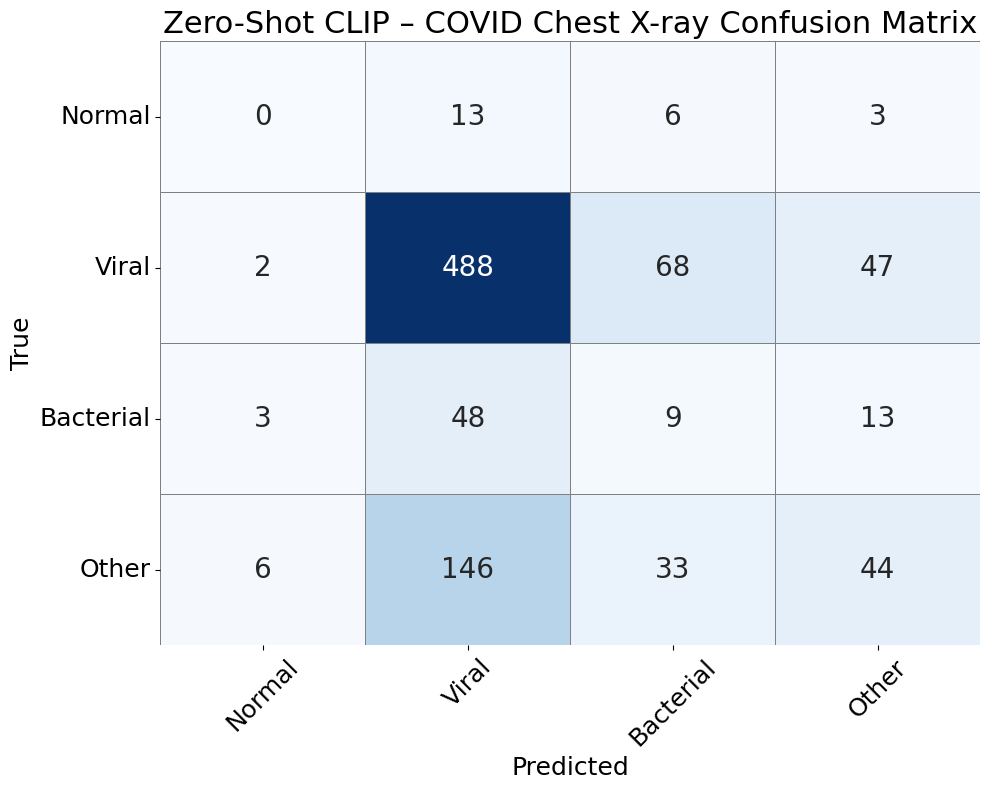

In [ ]:
# # ====== RESEARCH-GRADE METRICS FOR 4-CLASS COVID CHEST XRAY ======
# from sklearn.metrics import (
#     classification_report, confusion_matrix, top_k_accuracy_score,
#     balanced_accuracy_score, matthews_corrcoef, precision_recall_fscore_support
# )
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# # Use your stored variables
# y_true = np.array(all_labels)
# y_pred = np.array(all_preds)
# y_scores = np.array(all_logits)

# class_names = ["Normal", "Viral", "Bacterial", "Other"]
# num_classes = len(class_names)

# # ============================
# # 1. Top-k accuracies
# # ============================
# top1 = np.mean(y_pred == y_true)
# top2 = top_k_accuracy_score(y_true, y_scores, k=2)
# top3 = top_k_accuracy_score(y_true, y_scores, k=3)

# # ============================
# # 2. Standard classification metrics
# # ============================
# precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
#     y_true, y_pred, average='macro'
# )
# precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
#     y_true, y_pred, average='weighted'
# )

# balanced_acc = balanced_accuracy_score(y_true, y_pred)
# mcc = matthews_corrcoef(y_true, y_pred)

# # ============================
# # 3. Specificity per class
# # ============================
# cm = confusion_matrix(y_true, y_pred)
# specificity_per_class = []
# for i in range(num_classes):
#     tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
#     fp = cm[:, i].sum() - cm[i, i]
#     specificity_per_class.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
# specificity_macro = np.mean(specificity_per_class)

# # ============================
# # 4. Per-class accuracy
# # ============================
# per_class_acc = cm.diagonal() / cm.sum(axis=1)

# # ============================
# # PRINT RESULTS
# # ============================
# print("COVID CHEST XRAY – COMPLETE ZERO-SHOT RESULTS")
# print("="*60)
# print(f"Top-1 Accuracy       : {top1:.4f}  →  {top1*100:05.2f}%")
# print(f"Top-2 Accuracy       : {top2:.4f}  →  {top2*100:05.2f}%")
# print(f"Top-3 Accuracy       : {top3:.4f}  →  {top3*100:05.2f}%")
# print(f"Balanced Accuracy    : {balanced_acc:.4f}")
# print(f"Matthews Corr Coef   : {mcc:.4f}")
# print(f"Macro F1-score       : {f1_macro:.4f}")
# print(f"Weighted F1-score    : {f1_weighted:.4f}")
# print(f"Macro Specificity    : {specificity_macro:.4f}")

# # ============================
# # Per-class output table
# # ============================
# df_per_class = pd.DataFrame({
#     'Class': class_names,
#     'Accuracy': per_class_acc,
#     'Specificity': specificity_per_class
# }).sort_values('Accuracy')

# print("\nPer-class Accuracy (worst → best)")
# print(df_per_class.round(4).to_string(index=False))

# # ============================
# # Confusion Matrix Plot
# # ============================
# plt.figure(figsize=(10, 8))
# ax = sns.heatmap(
#     cm,
#     annot=True,
#     fmt='d',
#     cmap='Blues',
#     xticklabels=class_names,
#     yticklabels=class_names,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='gray'
# )

# for t in ax.texts:
#     t.set_fontsize(20)

# plt.title('Zero-Shot CLIP – COVID Chest X-ray Confusion Matrix', fontsize=22)
# plt.xlabel('Predicted', fontsize=18)
# plt.ylabel('True', fontsize=18)
# plt.xticks(rotation=45, fontsize=18)
# plt.yticks(rotation=0, fontsize=18)
# plt.tight_layout()
# plt.show()



=== OVERALL METRICS ===
Accuracy           : 58.23%
Precision (Macro)  : 29.77%
Recall/Sensitivity : 28.05%
Specificity (Macro): 78.35%

=== PER-CLASS METRICS ===
    Class  Precision  Recall  F1-score  Support
   Normal     0.0000  0.0000    0.0000     22.0
    Viral     0.7022  0.8066    0.7508    605.0
Bacterial     0.0776  0.1233    0.0952     73.0
    Other     0.4112  0.1921    0.2619    229.0


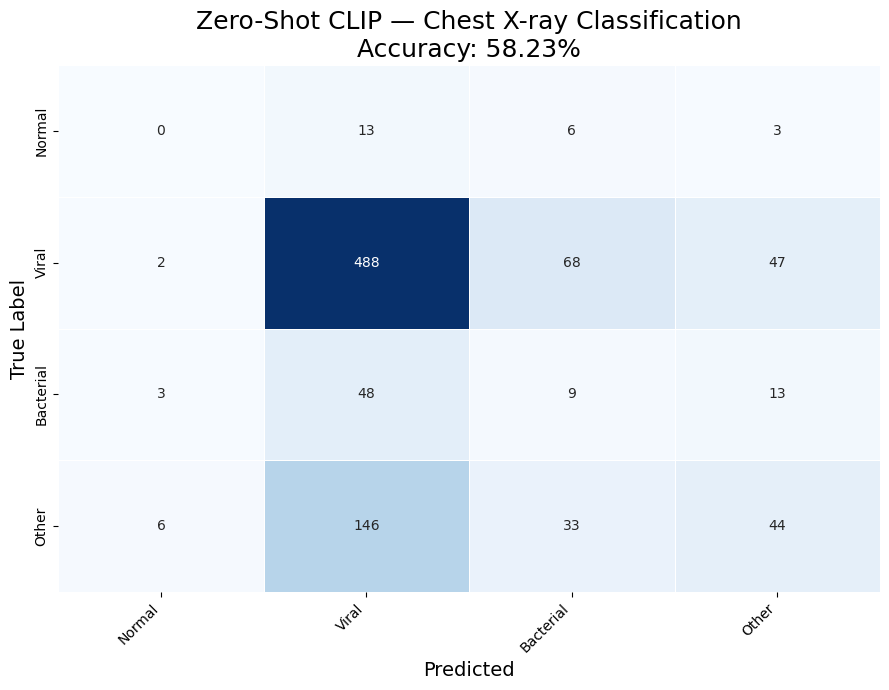

In [ ]:
# ==========================================================
# CELL 6 — FINAL METRICS FOR PRESENTATION (Chest X-ray Version)
# ==========================================================
from sklearn.metrics import (
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure NumPy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

class_names = ["Normal", "Viral", "Bacterial", "Other"]

# -----------------------------
# 1. Precision, Recall, F1
# -----------------------------
report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4,
    output_dict=True
)

# Build per-class metrics table
per_class_metrics = pd.DataFrame({
    "Class": class_names,
    "Precision": [report[c]["precision"] for c in class_names],
    "Recall": [report[c]["recall"] for c in class_names],
    "F1-score": [report[c]["f1-score"] for c in class_names],
    "Support": [report[c]["support"] for c in class_names],
}).round(4)

# -----------------------------
# 2. Global Metrics
# -----------------------------
accuracy = (y_pred == y_true).mean()

macro_precision = report["macro avg"]["precision"]
macro_recall    = report["macro avg"]["recall"]
macro_f1        = report["macro avg"]["f1-score"]

# ---- Specificity (macro) ----
cm = confusion_matrix(y_true, y_pred)
specificities = []

for i in range(len(class_names)):
    tn = cm.sum() - (cm[i].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp)
    specificities.append(specificity)

macro_specificity = np.mean(specificities)

# -----------------------------
# 3. PRINT SUMMARY
# -----------------------------
print("\n=== OVERALL METRICS ===")
print(f"Accuracy           : {accuracy*100:.2f}%")
print(f"Precision (Macro)  : {macro_precision*100:.2f}%")
print(f"Recall/Sensitivity : {macro_recall*100:.2f}%")
print(f"Specificity (Macro): {macro_specificity*100:.2f}%")

print("\n=== PER-CLASS METRICS ===")
print(per_class_metrics.to_string(index=False))

# -----------------------------
# 4. Confusion Matrix Plot
# -----------------------------
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, linewidths=0.5)
plt.title(f"Zero-Shot CLIP — Chest X-ray Classification\nAccuracy: {accuracy*100:.2f}%", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
